In [479]:
#| default_exp gaussian_invariance
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from diffusion_curvature.core import diffusion_matrix, plot_3d
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Diffusion Curvature from Invariance Properties of the Gaussian

The question: how to compute this?
For every point, we need:
1. two points surrounding it, of which our chosen point is the midpoint.

## Opposing neighbors from the underlying geometry
If we have access to the underlying point-cloud data in the form of euclidean coordinates from which the graph was constructed, then we can sample the pairs of opposing points around each target point with much greater ease. 

Specifically, given a point x, we choose one of x's neighbors, take the vector which is the difference between their locations, and 

## Opposing neighbors just given the graph
This is the harder case. Unmoored from the geometry, we have to estimate the opposition of neighbors using their joint affinities. 

The currently implementation works 90% of the time, but -- because it's greedy -- occasionally gives bad pairings. It also can't find opposing neighbors beyond the neighborhood of each point.

I plan to replace this with a more robust method.

In [480]:
def get_opposing_points_from_graph_neighbors(
    P:np.ndarray, # diffusion matrix
    k:int, # number of opposing pairs to sample for each point
    t:int, # number of steps from which to sample opposing pairs
    ) -> np.ndarray:
    Pt = np.linalg.matrix_power(P,t)
    # for each point x in the graph, computes k pairs of opposing points around x
    opposing_pairs = np.empty((len(P), k, 2))
    # TODO: This can likely be optimized
    for x in range(len(P)):
        # get k*4 neighborhood of x based on P (excluding x)
        # TODO: This algorithm is currently greedy, resulting in some suboptimal pairings
        near_neighbs = np.argpartition(P[x], -k*2-1)[-k*2-1:].tolist()
        if x in near_neighbs:
            near_neighbs.remove(x)
        else:
            near_neighbs.pop()
        n_count = 0
        while len(near_neighbs) > 0:
            neighb = near_neighbs.pop(0)
            diff_probs_from_neighb = Pt[neighb][near_neighbs]
            anti_neighb_idxs_in_near_neighbs = np.argmin(diff_probs_from_neighb)
            anti_neighb = near_neighbs.pop(anti_neighb_idxs_in_near_neighbs)
            opposing_pairs[x,n_count] = [neighb,anti_neighb]
            n_count += 1
    return opposing_pairs.astype(int)

In [481]:
coords_2d = np.random.rand(200,2)
P = diffusion_matrix(coords_2d,kernel_type="adaptive")
op = get_opposing_points_from_graph_neighbors(P, k = 4, t = 1)

In [482]:
Pt = np.linalg.matrix_power(P,1)

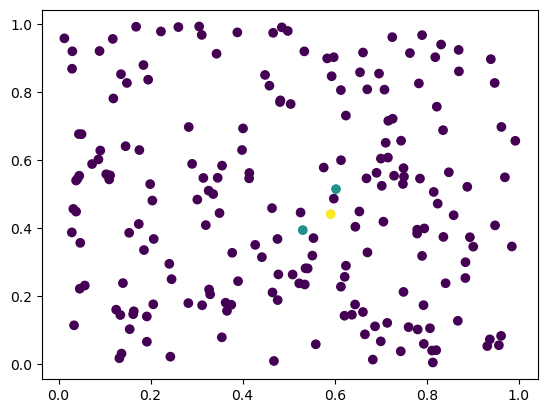

In [483]:
sig = np.zeros(len(P))
i = np.random.randint(len(op))
j = np.random.randint(4)
sig[i] = 2
sig[op[i][j]] = 1
plt.scatter(coords_2d[:,0],coords_2d[:,1],c=sig)

In [484]:
print(i)
print(op[i][j])

189
[125 120]


In [485]:
near_neighbs = np.argpartition(P[i], -4*2-1)[-4*2-1:].tolist()
print(Pt[op[i][j][0]][near_neighbs])
print(Pt[op[i][j][0]][op[i][j][1]])

[0.01362647 0.02301341 0.02537902 0.01726619 0.01933577 0.01787378
 0.02674734 0.0195328  0.02217737]
0.017266190903127157


In [1]:
#| export
import numpy as np
def compute_anisotropic_affinities_from_graph(
    A:np.ndarray, # the adjacency/affinity matrix of the graph
    alpha:float, # the anisotropic density normalization parameter
) -> np.ndarray:
    # normalize by density
    D = np.diag(1/np.sum(A,axis=1)**alpha)
    A_anis = D @ A @ D
    return A_anis

def compute_anisotropic_diffusion_matrix_from_graph(
    A:np.ndarray, # the adjacency/affinity matrix of the graph
    alpha:float, # the anisotropic density normalization parameter
    ) -> np.ndarray:
    A_anis = compute_anisotropic_affinities_from_graph(A,alpha)
    # row normalize to create diffusion matrix
    D = np.diag(1/np.sum(A_anis,axis=1))
    P = D @ A_anis
    return P

In [487]:
#| export
def gaussian_invariant_curvature_of_graph(
    A:np.ndarray, # adjacency/affinity matrix. Must be based on anisotropic kernel for theory to work.
    t:int = 5,
    k:int = 4,
    return_avg:bool = True, # whether to average the scalar curvature values to combat local density
    ):
    """
    Computes a signed point-wise curvature estimate by comparing the 
    product of 2 diffusions with the half-time diffusion.
    In euclidean space, these should be equal.
    """
    # calculate anisotropic diffusion matrix
    P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
    # Get pairs of opposing neighbors for each point
    op = get_opposing_points_from_graph_neighbors(P,k=k,t=1)
    # perform two iterations of diffusion
    Pt1 = np.linalg.matrix_power(P,t)
    Pt2 = np.linalg.matrix_power(Pt1,t)
    # for each set of opposing neighbors, extract the larger scale diffusion at that point
    P_t2_op1 = Pt2[op[:,:,0]]
    P_t2_op2 = Pt2[op[:,:,1]]
    # take the product of these, and normalize to sum to one
    P_t2_products = P_t2_op1 * P_t2_op2
    P_t2_products = P_t2_products / np.sum(P_t2_products,axis=2)[:,:,None]
    # extract the halved diffusion from the (likely) midpoint
    P_t1_midpoint_halved = np.repeat(Pt1[:,None,:],[k],axis=1)
    # take the differences between these
    curvature_diffs = np.sum(P_t2_products - P_t1_midpoint_halved,axis=2)
    # sum them for the scalar curvature
    scalar_k = np.sum(curvature_diffs,axis=1)/k
    if return_avg:
        # average scalar k
        scalar_k_avg = scalar_k @ P 
        return scalar_k_avg, curvature_diffs
    else:
        return scalar_k, curvature_diffs


# Testing on Example Datasets

## The Plane

In [488]:
coords_2d = np.random.rand(1000,2)
A = gaussian_kernel(coords_2d,kernel_type="adaptive")

In [489]:
ks_p, kdiffs = gaussian_invariant_curvature_of_graph(A, t = 5)

In [490]:
ks_p

array([4.93762373e-16, 5.90059557e-16, 7.50158315e-16, 6.59743694e-16,
       5.59877045e-16, 5.97954630e-16, 6.04949156e-16, 5.58946360e-16,
       5.32876324e-16, 4.80281933e-16, 5.91219463e-16, 5.09137720e-16,
       5.48226060e-16, 6.54644894e-16, 4.71409304e-16, 4.64125396e-16,
       6.59934871e-16, 4.66740489e-16, 6.61853813e-16, 6.07644535e-16,
       5.54028896e-16, 8.66600863e-16, 4.60626644e-16, 5.64620180e-16,
       8.66083655e-16, 5.90684800e-16, 5.49841347e-16, 5.48150316e-16,
       5.67234408e-16, 5.94728091e-16, 5.31462154e-16, 5.95609274e-16,
       5.34582881e-16, 5.52483447e-16, 6.57931892e-16, 5.95300316e-16,
       5.59972598e-16, 6.06063860e-16, 6.47854863e-16, 8.25939443e-16,
       6.15584459e-16, 5.59937209e-16, 5.62306970e-16, 6.06881389e-16,
       5.62906669e-16, 5.83023368e-16, 5.34280262e-16, 5.71361454e-16,
       5.86084821e-16, 5.65693353e-16, 6.96308550e-16, 5.83002527e-16,
       5.40353972e-16, 5.69957107e-16, 5.74607590e-16, 6.01962769e-16,
      

In [491]:
print(f"min {min(ks_p)} vs max {max(ks_p)} with factor of {max(ks_p)/min(ks_p)}")

min 4.579009057460483e-16 vs max 8.740555082428099e-16 with factor of 1.908831140700038


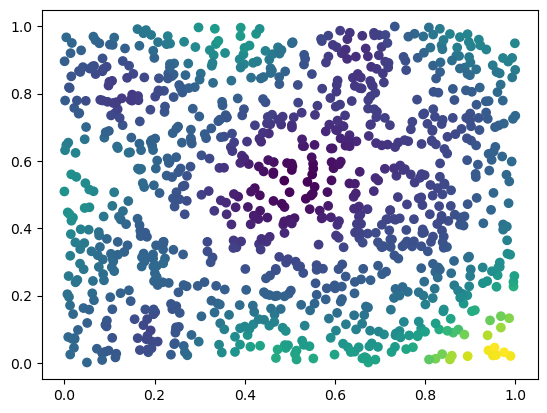

In [492]:
plt.scatter(coords_2d[:,0],coords_2d[:,1],c=ks_p)

As desired, the curvature is very low and fairly smooth.

## The Ellipsoid

In [493]:
from diffusion_curvature.datasets import ellipsoid

In [494]:
X,ks_true = ellipsoid(n=2000)
A = gaussian_kernel(X,kernel_type="adaptive")

In [495]:
ks_p, kdiffs = gaussian_invariant_curvature_of_graph(A, t = 2,k=4,return_avg=False)

In [496]:
print(f"min {min(ks_p)} vs max {max(ks_p)} with factor of {max(ks_p)/min(ks_p)}")

min -1.345494896054511e-16 vs max 5.672003665357916e-16 with factor of -4.2155519742143435


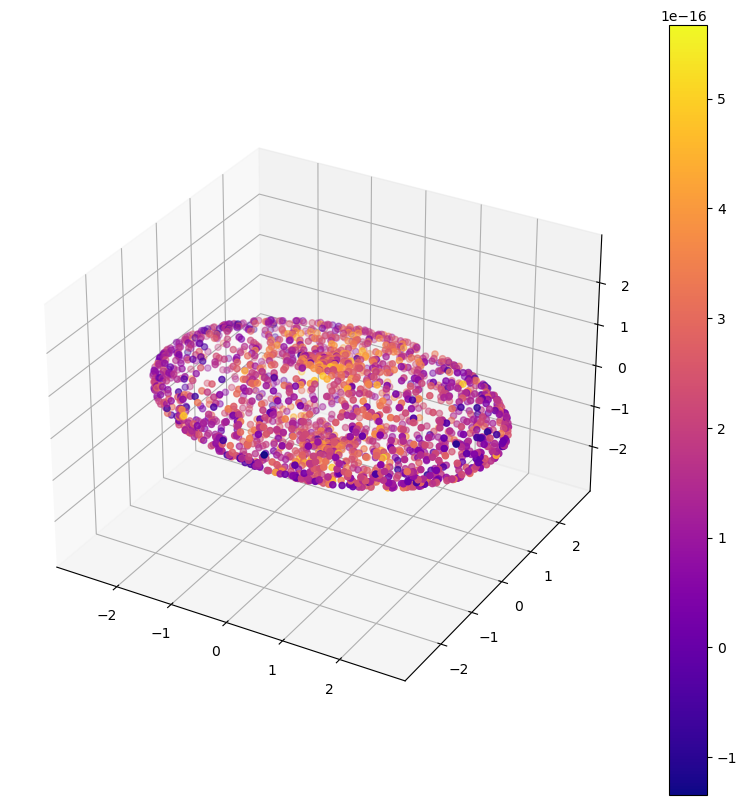

In [497]:
plot_3d(X,ks_p,colorbar=True)

## Torus

In [498]:
from diffusion_curvature.datasets import torus

In [499]:
X,ks_true = torus(n=2000)
A = gaussian_kernel(X,kernel_type="adaptive")

In [500]:
ks_p, kdiffs = gaussian_invariant_curvature_of_graph(A, t = 5,k=8,return_avg=False)

In [501]:
print(f"min {min(ks_p)} vs max {max(ks_p)} with factor of {max(ks_p)/min(ks_p)}")

min -1.1926223897340549e-17 vs max 9.059593353288875e-16 with factor of -75.96363636363637


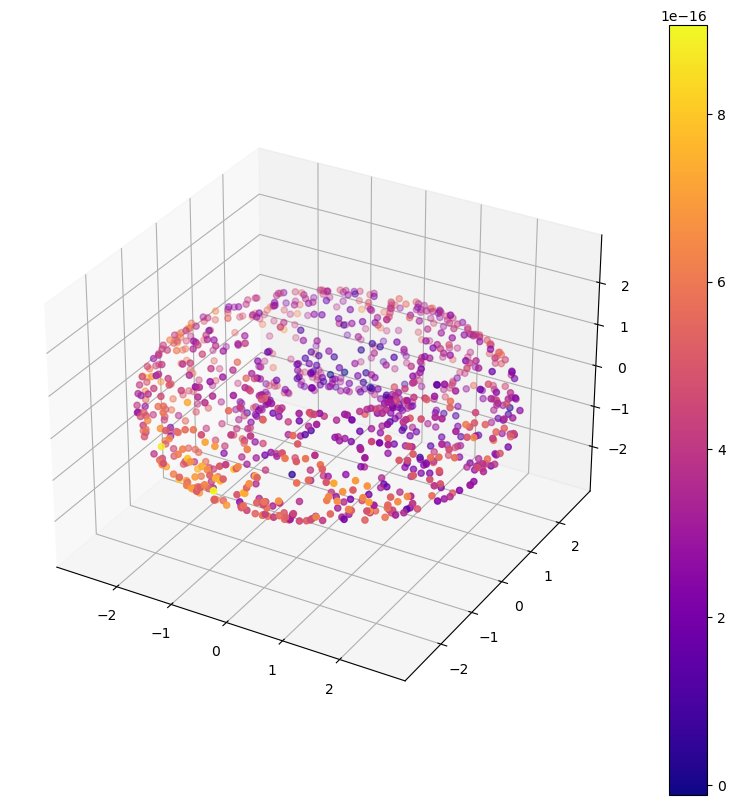

In [502]:
plot_3d(X,ks_p,colorbar=True)